In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
# np.set_printoptions(threshold=np.inf, linewidth=200, suppress=True)

In [2]:
# Path to your .mat file
mat_file_path = 'Data/s01.mat' 

mat = loadmat(
    mat_file_path,
    struct_as_record=False,   # access fields as attributes
    squeeze_me=True,          # drop trivial dimensions (so 1x1 -> scalar)
    simplify_cells=True       # convert MATLAB cell arrays to Python lists
)

In [3]:
print(mat["eeg"].keys())

dict_keys(['noise', 'rest', 'srate', 'movement_left', 'movement_right', 'movement_event', 'n_movement_trials', 'imagery_left', 'imagery_right', 'n_imagery_trials', 'frame', 'imagery_event', 'comment', 'subject', 'bad_trial_indices', 'psenloc', 'senloc'])


In [4]:
for key in mat["eeg"].keys():
    print(key)

noise
rest
srate
movement_left
movement_right
movement_event
n_movement_trials
imagery_left
imagery_right
n_imagery_trials
frame
imagery_event
comment
subject
bad_trial_indices
psenloc
senloc


In [5]:
eeg = mat["eeg"]
for key in eeg.keys():
    data = eeg[key]
    print("Key: ", key)
    print("Type: ", type(data))
    try:
        print("Shape: ", data.shape)
    except:
        print("No associated shape, Value -> ", data)
        
    print("n/n")
    

Key:  noise
Type:  <class 'numpy.ndarray'>
Shape:  (5,)
n/n
Key:  rest
Type:  <class 'numpy.ndarray'>
Shape:  (68, 34048)
n/n
Key:  srate
Type:  <class 'int'>
No associated shape, Value ->  512
n/n
Key:  movement_left
Type:  <class 'numpy.ndarray'>
Shape:  (68, 71680)
n/n
Key:  movement_right
Type:  <class 'numpy.ndarray'>
Shape:  (68, 71680)
n/n
Key:  movement_event
Type:  <class 'numpy.ndarray'>
Shape:  (71680,)
n/n
Key:  n_movement_trials
Type:  <class 'int'>
No associated shape, Value ->  20
n/n
Key:  imagery_left
Type:  <class 'numpy.ndarray'>
Shape:  (68, 358400)
n/n
Key:  imagery_right
Type:  <class 'numpy.ndarray'>
Shape:  (68, 358400)
n/n
Key:  n_imagery_trials
Type:  <class 'int'>
No associated shape, Value ->  100
n/n
Key:  frame
Type:  <class 'numpy.ndarray'>
Shape:  (2,)
n/n
Key:  imagery_event
Type:  <class 'numpy.ndarray'>
Shape:  (358400,)
n/n
Key:  comment
Type:  <class 'str'>
No associated shape, Value ->  bci2011v1 left/right motor imagery
n/n
Key:  subject
Type:  <c

In [6]:
print(eeg["comment"])
print(eeg["subject"])

bci2011v1 left/right motor imagery
subject 1


In [7]:
print(eeg["frame"])

[-2000  5000]


In [8]:
print(np.unique(eeg["imagery_event"]))

[0 1]


In [9]:
### Starting with Movement Left Data and exploring PSD ###


movement_left = eeg["movement_left"]
print("Original movement left shape: ", movement_left.shape)

fs = eeg["srate"]
movement_left_data = movement_left[:64, :]  # EEG channels only, drop the auxiliary channels
n_trials = eeg["n_movement_trials"]
samples_per_trial = movement_left_data.shape[1] // n_trials
movement_left_epochs = np.reshape(movement_left_data, (64, samples_per_trial, n_trials), order='F')
print(movement_left_epochs.shape)

Original movement left shape:  (68, 71680)
(64, 3584, 20)


In [10]:
print(movement_left_epochs[:5,:5,0])

[[  -9773.996   -9950.996  -10090.496   -9941.496  -10098.996]
 [-168767.25  -168754.5   -168889.75  -168742.25  -168829.   ]
 [-168224.25  -168037.5   -168162.75  -168323.75  -168639.5  ]
 [ 393200.5    393191.25   392958.     392815.     392680.25 ]
 [ 483607.25   483541.75   483300.     483150.75   483144.75 ]]


In [11]:
from scipy.signal import welch

movement_left_epoch = movement_left_epochs[0, :, 0]  # 1 channel, 1 trial, shape: (samples,)

f, Pxx = welch(movement_left_epoch, fs=fs, nperseg=fs*2)

In [12]:
print("frequency: ", f[:10])
print("Pxx: ", Pxx[:10])

frequency:  [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
Pxx:  [3.27999094e+05 9.60666562e+05 1.04702675e+06 7.51579375e+05
 4.64011000e+05 3.03348438e+05 1.82719875e+05 1.07683547e+05
 6.78772422e+04 4.89617148e+04]


In [13]:
# Create the support for looking at critical repeating brain activity
bands = {
    "delta_band": (.5, 4),
    "theta_band": (4, 8),
    "mu_band": (8, 13),
    "beta_band": (13, 30),
    "gamma_band": (30, 45)
}

def make_band_masks(f, bands=bands):
    names  = list(bands.keys())
    bounds = np.array([bands[name] for name in names])     # (n_bands, 2)
    # mask: (n_freq, n_bands)
    mask = (f[:, None] >= bounds[:, 0]) & (f[:, None] <= bounds[:, 1])
    return names, mask

names, mask = make_band_masks(f)

band_pxx = np.where(mask, Pxx[:, None], 0.0)              # (n_freq, n_bands)
bandpowers = np.trapezoid(band_pxx, f, axis=0)               # (n_bands,)
bandpowers_dict = dict(zip(names, bandpowers))
    
print(bandpowers_dict)

{'delta_band': np.float64(1942456.380859375), 'theta_band': np.float64(99630.27990722656), 'mu_band': np.float64(35906.64727783203), 'beta_band': np.float64(22809.13800048828), 'gamma_band': np.float64(9234.711944580078)}


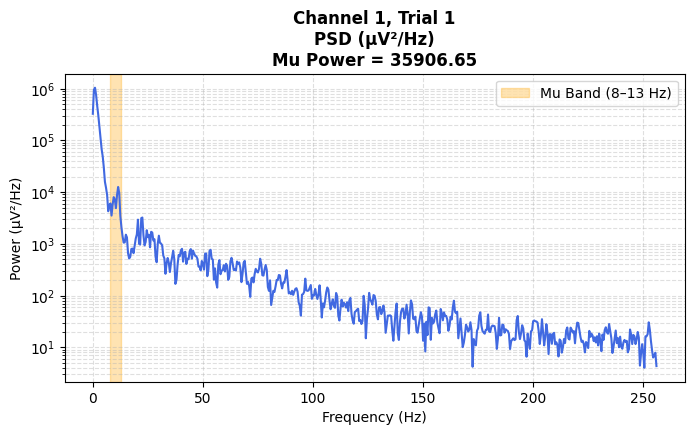

In [14]:
plt.figure(figsize=(8, 4))
plt.semilogy(f, Pxx, color='royalblue')
plt.axvspan(bands["mu_band"][0], bands["mu_band"][1], color='orange', alpha=0.3, label='Mu Band (8–13 Hz)')
plt.title(f'Channel 1, Trial 1\nPSD (µV²/Hz)\nMu Power = {bandpowers_dict["mu_band"]:.2f}', fontsize=12, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

In [15]:
movement_left_epoch = movement_left_epochs[13, :, 0]  # 1 channel, 1 trial, shape: (samples,)

f, Pxx = welch(movement_left_epoch, fs=fs, nperseg=fs*2)
band_pxx = np.where(mask, Pxx[:, None], 0.0)              # (n_freq, n_bands)
bandpowers = np.trapezoid(band_pxx, f, axis=0)               # (n_bands,)
bandpowers_dict = dict(zip(names, bandpowers))
    
print(bandpowers_dict)

{'delta_band': np.float64(48791.39553833008), 'theta_band': np.float64(5396.599456787109), 'mu_band': np.float64(15484.516098022461), 'beta_band': np.float64(8608.077751159668), 'gamma_band': np.float64(3032.3911685943604)}


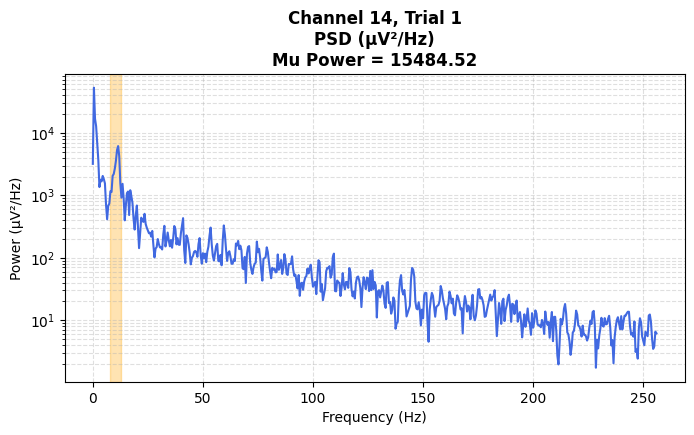

In [16]:
plt.figure(figsize=(8, 4))
plt.semilogy(f, Pxx, color='royalblue')
plt.axvspan(bands["mu_band"][0], bands["mu_band"][1], color='orange', alpha=0.3, label='Mu Band (8–13 Hz)')
plt.title(f'Channel 14, Trial 1\nPSD (µV²/Hz)\nMu Power = {bandpowers_dict["mu_band"]:.2f}', fontsize=12, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

In [17]:
movement_events = eeg["movement_event"]
print(movement_events.shape)
print(movement_events.shape[0])

(71680,)
71680


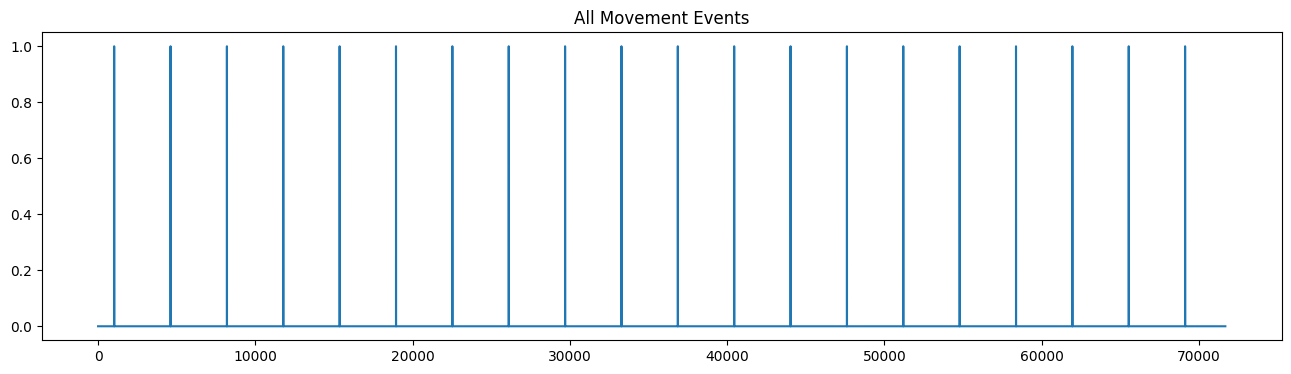

In [18]:
plt.figure(figsize=(16, 4))
plt.title("All Movement Events")
plt.plot(movement_events)
plt.show()

In [19]:
samples_per_trial = movement_events.shape[0] // n_trials
event_marker_epochs = np.reshape(movement_events, (1, samples_per_trial, n_trials), order='F')

In [20]:
print(event_marker_epochs.shape)

(1, 3584, 20)


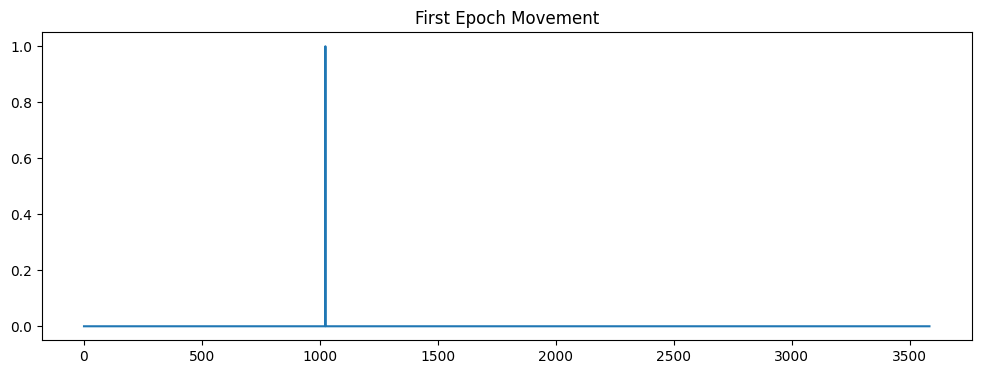

In [21]:
plt.figure(figsize=(12, 4))
plt.title("First Epoch Movement")
plt.plot(event_marker_epochs[0,:,0])
plt.show()

In [22]:
for n in range(event_marker_epochs.shape[2]):
    event_marker_epoch = event_marker_epochs[0,:,n]
    values, counts = np.unique(event_marker_epoch, return_counts=True)
    first_one_index = np.argmax(event_marker_epoch == 1)
    print("Values: ", values)
    print("Counts: ", counts)
    print("First 1 Index: ", first_one_index)
    print("/n/n")

Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values:  [0 1]
Counts:  [3583    1]
First 1 Index:  1023
/n/n
Values: 

Looks like the movement event happens at the exact same sample for every trial and is just a "start" indicator.

# Looking at PSD Before and During Movement Events.

Lets breakdown one of the existing epochs into 2 sections and look at how band power changes. Lets start with one electrode that is around the motor cortex (13) and once that is working expand out to more electrodes.

In [23]:
ch14_e1 = movement_left_epochs[13,:,0]
print(ch14_e1.shape)

(3584,)


In [24]:
# Movement event occurs at 1023, split into :512, 512:3000, 3000:
before = ch14_e1[:1024]
during = ch14_e1[1024:]
# after = ch14_e1[3000:]

print("Before: ", before.shape)
print("During: ", during.shape)
# print("After: ", after.shape)

Before:  (1024,)
During:  (2560,)


In [25]:
# Full Epoch
full_f, full_Pxx = welch(ch14_e1, fs=fs, nperseg=min(fs*2, len(ch14_e1)))

full_band_pxx = np.where(mask, full_Pxx[:, None], 0.0)              # (n_freq, n_bands)
full_bandpowers = np.trapezoid(full_band_pxx, full_f, axis=0)               # (n_bands,)
full_bandpowers_dict = dict(zip(names, full_bandpowers))
    
print(full_bandpowers_dict)

{'delta_band': np.float64(48791.39553833008), 'theta_band': np.float64(5396.599456787109), 'mu_band': np.float64(15484.516098022461), 'beta_band': np.float64(8608.077751159668), 'gamma_band': np.float64(3032.3911685943604)}


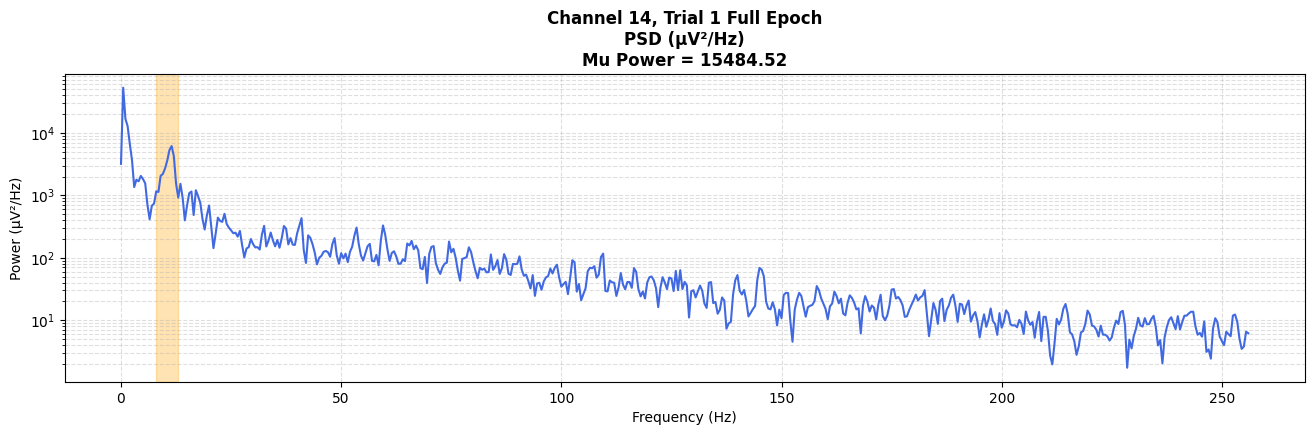

In [26]:
plt.figure(figsize=(16, 4))
plt.semilogy(full_f, full_Pxx, color='royalblue')
plt.axvspan(bands["mu_band"][0], bands["mu_band"][1], color='orange', alpha=0.3, label='Mu Band (8–13 Hz)')
plt.title(f'Channel 14, Trial 1 Full Epoch\nPSD (µV²/Hz)\nMu Power = {full_bandpowers_dict["mu_band"]:.2f}', fontsize=12, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

In [27]:
# Before the movement
before_f, before_Pxx = welch(before, fs=fs, nperseg=fs*2)

before_band_pxx = np.where(mask, before_Pxx[:, None], 0.0)              # (n_freq, n_bands)
before_bandpowers = np.trapezoid(before_band_pxx, before_f, axis=0)               # (n_bands,)
before_bandpowers_dict = dict(zip(names, before_bandpowers))

print(before_bandpowers_dict)

{'delta_band': np.float64(69545.13543701172), 'theta_band': np.float64(4048.5669021606445), 'mu_band': np.float64(16764.591060638428), 'beta_band': np.float64(8726.282696723938), 'gamma_band': np.float64(3195.397638320923)}


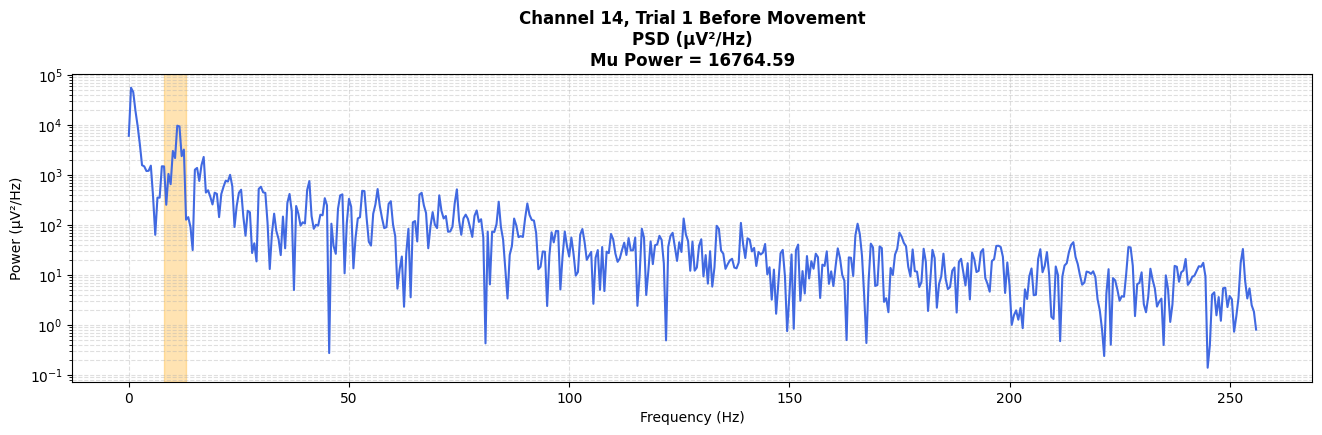

In [28]:
plt.figure(figsize=(16, 4))
plt.semilogy(before_f, before_Pxx, color='royalblue')
plt.axvspan(bands["mu_band"][0], bands["mu_band"][1], color='orange', alpha=0.3, label='Mu Band (8–13 Hz)')
plt.title(f'Channel 14, Trial 1 Before Movement\nPSD (µV²/Hz)\nMu Power = {before_bandpowers_dict["mu_band"]:.2f}', fontsize=12, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

In [29]:
during_f, during_Pxx = welch(during, fs=fs, nperseg=fs*2)

during_band_pxx = np.where(mask, during_Pxx[:, None], 0.0)              # (n_freq, n_bands)
during_bandpowers = np.trapezoid(during_band_pxx, during_f, axis=0)               # (n_bands,)
during_bandpowers_dict = dict(zip(names, during_bandpowers))

print(during_bandpowers_dict)

# during_mu_power = np.trapezoid(during_Pxx[mu_band_mask], during_f[mu_band_mask])

{'delta_band': np.float64(49455.03240966797), 'theta_band': np.float64(4529.449722290039), 'mu_band': np.float64(9739.867950439453), 'beta_band': np.float64(9093.185619354248), 'gamma_band': np.float64(3332.3455715179443)}


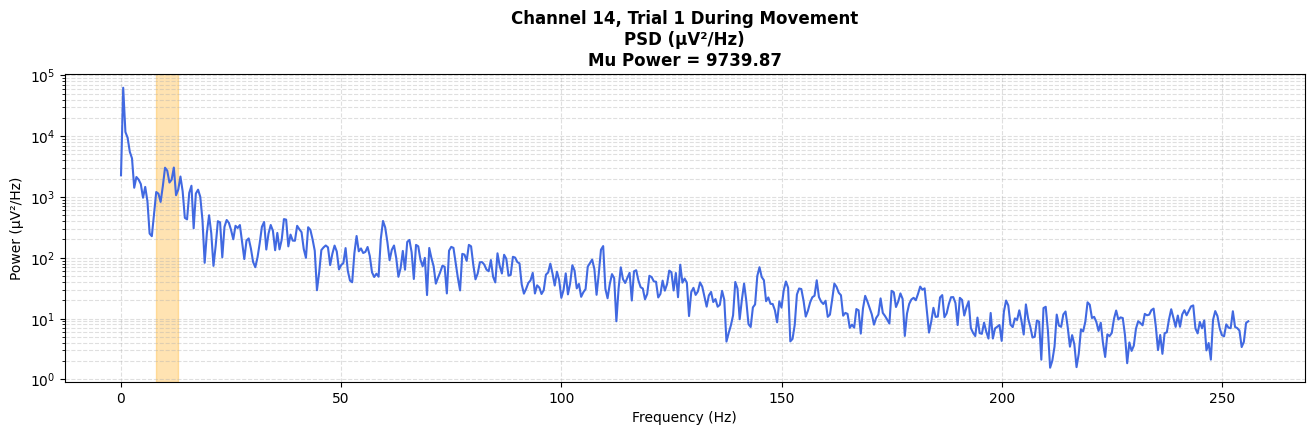

In [30]:
plt.figure(figsize=(16, 4))
plt.semilogy(during_f, during_Pxx, color='royalblue')
plt.axvspan(bands["mu_band"][0], bands["mu_band"][1], color='orange', alpha=0.3, label='Mu Band (8–13 Hz)')
plt.title(f'Channel 14, Trial 1 During Movement\nPSD (µV²/Hz)\nMu Power = {during_bandpowers_dict["mu_band"]:.2f}', fontsize=12, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (µV²/Hz)')
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.show()

## Summary

You can see that the Mu power before the movement is higher than the Mu power of the segment after the movement. This supports that there could have been motor movement at the marker, because a decrease in resting Mu is idicative of a motor event.

Let's keep working on one epoch - but lets add all the channels now.

In [31]:
# gotta work with this variable movement_left_epochs
print(movement_left_epochs.shape)
print(mask.shape)
psenloc = eeg["psenloc"]

(64, 3584, 20)
(513, 5)


In [32]:
def calculate_bandpowers(single_channel_data, masks):
    f, Pxx = welch(single_channel_data, fs=fs, nperseg=fs*2)
    # print("Pxx shape: ", Pxx.shape)
    band_pxx = np.where(masks, Pxx[:, None], 0.0)              # (n_freq, n_bands)
    bandpowers = np.trapezoid(band_pxx, during_f, axis=0)               # (n_bands,)
    bandpowers_dict = dict(zip(names, bandpowers))
    return bandpowers_dict

In [37]:
channel_bandpowers = {}

for i in range(movement_left_epochs.shape[0]):
    channel_data = movement_left_epochs[i,:,0] # working with all channels (i), for full epoch time series (:), but only the first epoch (0)
    # print(channel_data[:10])
    before = channel_data[:1024]
    during = channel_data[1024:]
    # print(before.shape)
    # print(during.shape)
    before_bandpowers = calculate_bandpowers(before, mask)
    during_bandpowers = calculate_bandpowers(during, mask)
    # print(before_bandpowers)
    # print(during_bandpowers)
    channel_bandpowers[str(i+1)] = {
        "before": before_bandpowers,
        "during": during_bandpowers
    }

    


In [38]:
print(channel_bandpowers.keys())
print(channel_bandpowers["1"])
print(channel_bandpowers["2"])
print(channel_bandpowers["3"])


dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64'])
{'before': {'delta_band': np.float64(62464.45050048828), 'theta_band': np.float64(11953.470184326172), 'mu_band': np.float64(12056.351442337036), 'beta_band': np.float64(25341.238805770874), 'gamma_band': np.float64(11301.12955570221)}, 'during': {'delta_band': np.float64(1581722.451171875), 'theta_band': np.float64(88117.86364746094), 'mu_band': np.float64(23763.40557861328), 'beta_band': np.float64(22829.297164916992), 'gamma_band': np.float64(7497.242477416992)}}
{'before': {'delta_band': np.float64(50953.60021972656), 'theta_band': np.float64(12238.012390136719), 'mu_band': np.float64(13886.29958724975

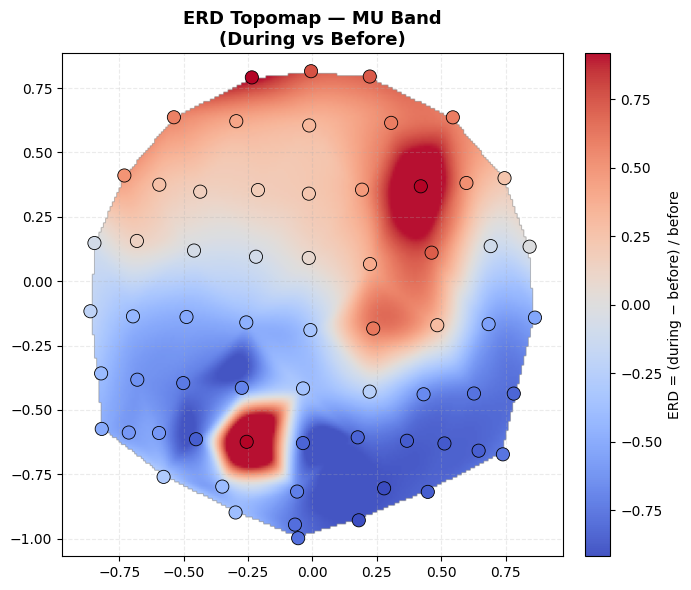

mu_band Regional ERD means: {'Left': -0.10362811098247449, 'Mid': -0.4420155967100581, 'Right': -0.12460978155733848}


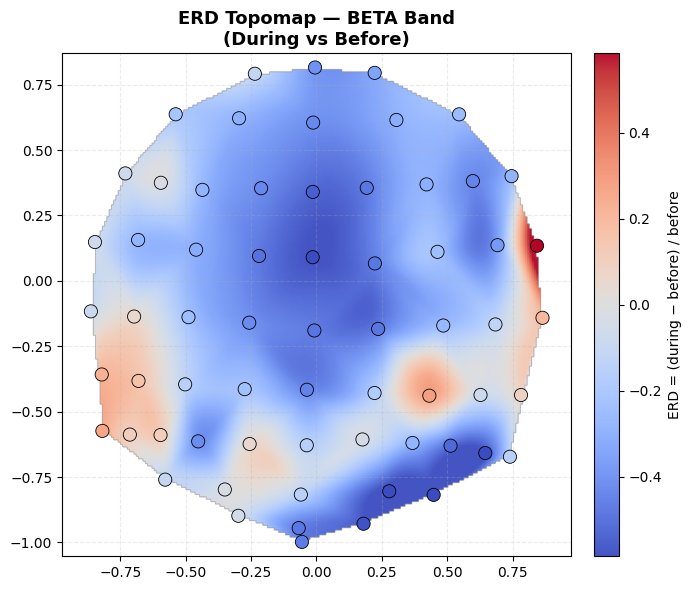

beta_band Regional ERD means: {'Left': -0.12003001876226287, 'Mid': -0.3385586706671993, 'Right': -0.27216283045376904}


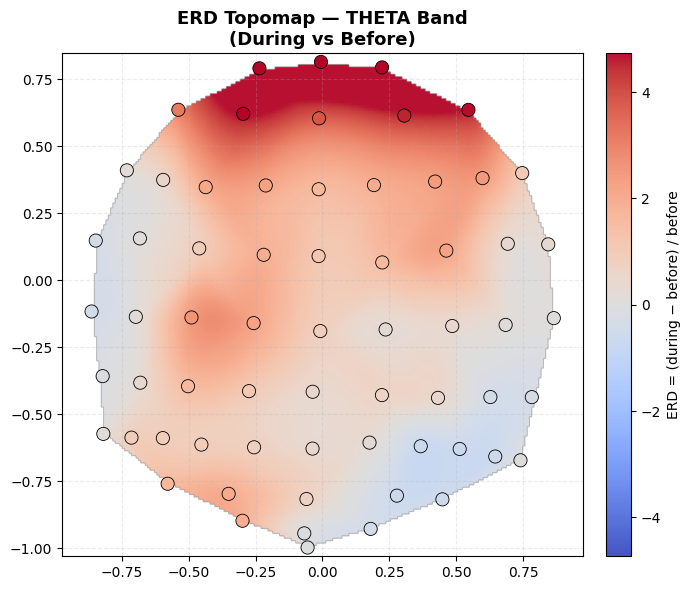

theta_band Regional ERD means: {'Left': 1.3924405597977474, 'Mid': 1.4024142814527139, 'Right': 1.0954922312992263}


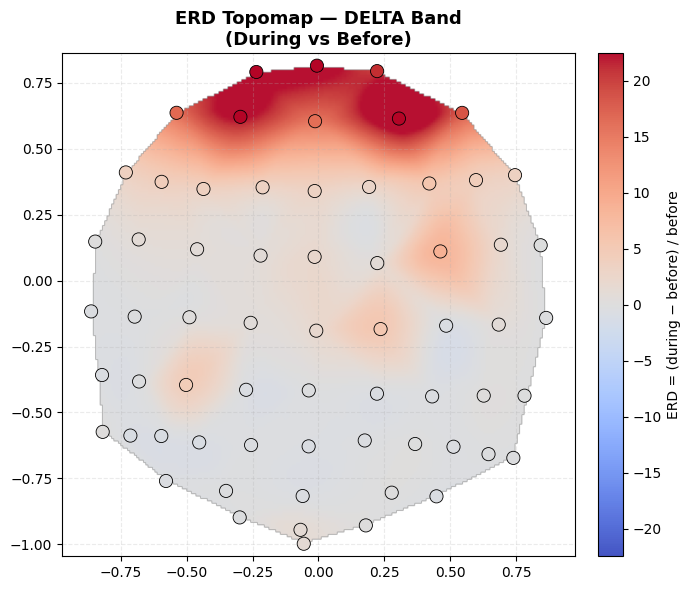

delta_band Regional ERD means: {'Left': 2.9421444095663825, 'Mid': 4.289097308702449, 'Right': 3.729517920131184}


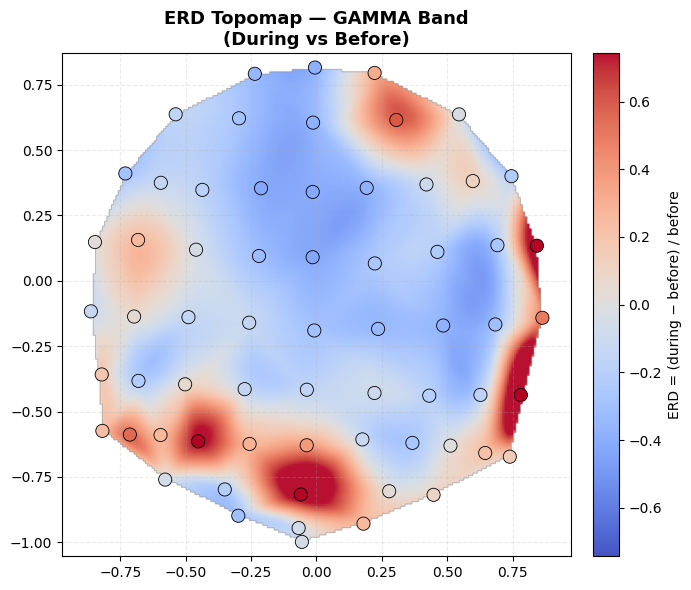

gamma_band Regional ERD means: {'Left': -0.0293322871537766, 'Mid': 0.10841879458066273, 'Right': 0.002033580134891054}


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# =========================================================
# 1) Compute ERD from your channel_bandpowers dictionary
# =========================================================
def compute_erd_from_dict(channel_bandpowers, band_name, before_key="before", during_key="during", eps=1e-12):
    """
    Compute ERD per channel for a given band from a dict like:
      channel_bandpowers = {
        "1": {"before": {"mu_band": float, ...}, "during": {...}},
        ...
        "64": {...}
      }

    Robust to a 'berfore' misspelling. Returns:
      erd: np.ndarray (64,) with ERD values; NaN where missing
      valid_mask: np.ndarray (64,) True where ERD is valid
    """
    erd = np.full(64, np.nan, dtype=float)
    valid_mask = np.zeros(64, dtype=bool)

    # Detect typo 'berfore' once, if present
    if channel_bandpowers:
        first_key = next(iter(channel_bandpowers.keys()))
        first_entry = channel_bandpowers[first_key]
        if before_key not in first_entry and "berfore" in first_entry:
            before_key = "berfore"

    for ch_str, ch_dict in channel_bandpowers.items():
        # accept only channel keys 1..64
        try:
            ch_idx0 = int(ch_str) - 1
        except Exception:
            continue
        if not (0 <= ch_idx0 < 64):
            continue

        # must have both before & during dicts
        if before_key not in ch_dict or during_key not in ch_dict:
            continue
        b_dict = ch_dict[before_key]
        d_dict = ch_dict[during_key]
        if band_name not in b_dict or band_name not in d_dict:
            continue

        b = float(b_dict[band_name])
        d = float(d_dict[band_name])
        if not (np.isfinite(b) and np.isfinite(d)):
            continue

        denom = b if abs(b) > eps else (np.sign(b) * eps if b != 0 else eps)
        erd_val = (d - b) / denom
        erd[ch_idx0] = erd_val
        valid_mask[ch_idx0] = True

    return erd, valid_mask

# =========================================================
# 2) ERD topomap plot using psenloc (64x3)
# =========================================================
def plot_erd_topomap(
    psenloc,
    erd,
    band_name=None,
    cmap="coolwarm",
    vclip_percentile=95,
    annotate=True,
    three_groups=False,
    point_size=90,
):
    """
    psenloc: np.ndarray (64, 3) with projected coordinates (we use [:, :2])
    erd:     np.ndarray (64,) ERD per channel (NaN allowed)
    band_name: e.g. "mu_band"; used for a nice title label
    vclip_percentile: symmetric color scale clipping by |ERD| percentile
    annotate: draw bold channel numbers (1–64)
    three_groups: draw left/mid/right outlines for readability
    """
    assert psenloc.shape[0] >= 64 and psenloc.shape[1] >= 2, "psenloc must be (64, >=2)"
    xy = psenloc[:64, :2].copy()
    vals = erd.copy()

    # Robust symmetric color limits
    finite_vals = vals[np.isfinite(vals)]
    vlim = np.percentile(np.abs(finite_vals), vclip_percentile) if finite_vals.size else 1.0
    vlim = max(vlim, 1e-6)

    # Smooth background via interpolation
    gx, gy = np.mgrid[xy[:,0].min():xy[:,0].max():200j,
                      xy[:,1].min():xy[:,1].max():200j]
    try:
        gz = griddata((xy[:,0], xy[:,1]), vals, (gx, gy), method="cubic")
    except Exception:
        gz = griddata((xy[:,0], xy[:,1]), vals, (gx, gy), method="linear")

    plt.figure(figsize=(7, 6))
    im = plt.imshow(
        gz.T, origin="lower",
        extent=(xy[:,0].min(), xy[:,0].max(), xy[:,1].min(), xy[:,1].max()),
        cmap=cmap, vmin=-vlim, vmax=+vlim, alpha=0.95
    )

    # Electrode scatter on top
    plt.scatter(
        xy[:,0], xy[:,1],
        c=vals, cmap=cmap, vmin=-vlim, vmax=+vlim,
        s=point_size, edgecolor="black", linewidth=0.6, zorder=3
    )

    # Optional group outlines (left/mid/right)
    if three_groups:
        left_idx  = np.arange(0, 27)   # channels 1–27
        mid_idx   = np.arange(27, 33)  # channels 28–33
        right_idx = np.arange(33, 64)  # channels 34–64
        plt.scatter(xy[left_idx,0],  xy[left_idx,1],  facecolors="none", edgecolors="royalblue", s=180, linewidths=1.2)
        plt.scatter(xy[mid_idx,0],   xy[mid_idx,1],   facecolors="none", edgecolors="gold",      s=180, linewidths=1.2)
        plt.scatter(xy[right_idx,0], xy[right_idx,1], facecolors="none", edgecolors="crimson",   s=180, linewidths=1.2)

    # Bold channel numbers (1–64)
    if annotate:
        for i, (x, y) in enumerate(xy, start=1):
            plt.text(x, y, str(i), fontsize=9, fontweight="bold",
                     ha="center", va="center", color="black", zorder=4)

    band_label = f" — {band_name.replace('_band','').upper()} Band" if band_name else ""
    plt.title(f"ERD Topomap{band_label}\n(During vs Before)", fontsize=13, fontweight="bold")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label("ERD = (during − before) / before", fontsize=10)
    plt.axis("equal")
    plt.grid(True, linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.show()

# =========================================================
# 3) Regional summary (optional but handy)
# =========================================================
def print_regional_means(band, erd):
    left_idx  = np.arange(0, 27)   # 1–27
    mid_idx   = np.arange(27, 33)  # 28–33
    right_idx = np.arange(33, 64)  # 34–64
    print(f"{band} Regional ERD means:", {
        "Left":  float(np.nanmean(erd[left_idx])),
        "Mid":   float(np.nanmean(erd[mid_idx])),
        "Right": float(np.nanmean(erd[right_idx])),
    })

# =========================================================
# 4) Example usage
# =========================================================
# Required inputs already in your session:
#   - channel_bandpowers : dict with string keys "1".."64"
#   - psenloc            : np.ndarray shape (64, 3)

band = "mu_band"  # change to "beta_band", "theta_band", etc.

# erd_mu, valid = compute_erd_from_dict(channel_bandpowers, band_name=band)
# print(f"Valid ERD channels for {band}: {valid.sum()}/64")

# plot_erd_topomap(psenloc, erd_mu, band_name=band, annotate=True, three_groups=True, point_size=95)
# print_regional_means(erd_mu)

# (Optional) loop over multiple bands:
for band in ["mu_band", "beta_band", "theta_band", "delta_band", "gamma_band"]:
    erd, _ = compute_erd_from_dict(channel_bandpowers, band_name=band)
    plot_erd_topomap(psenloc, erd, band_name=band, annotate=False, three_groups=False)
    print_regional_means(band, erd)
